Population according to regions and buses

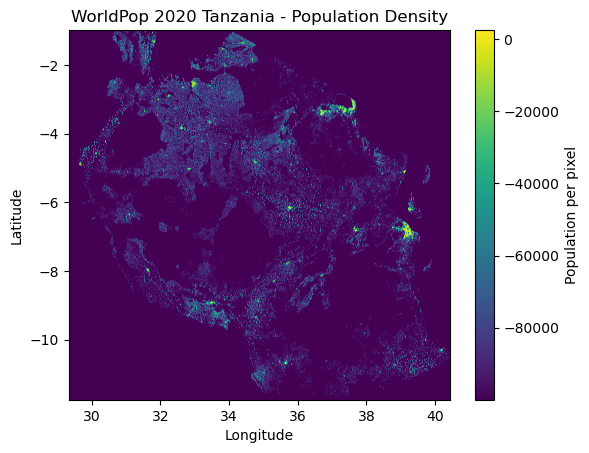

In [1]:
import rasterio
import matplotlib.pyplot as plt

tif_path = r"C:/Users/hie/pe_tan/pypsa-earth/data/WorldPop/tza_ppp_2020_UNadj_constrained.tif"

with rasterio.open(tif_path) as src:
    population = src.read(1)  # first (and only) band
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

plt.imshow(population, cmap='viridis', extent=extent)
plt.colorbar(label='Population per pixel')
plt.title('WorldPop 2020 Tanzania - Population Density')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


population per region according to World pop constrained (2020) pypsa-earth default- 

In [27]:


import rasterio
import geopandas as gpd
from rasterio.mask import mask
import numpy as np
import pandas as pd

# File paths
raster_path = r"C:/Users/hie/pe_tan/pypsa-earth/data/WorldPop/tza_ppp_2020_UNadj_constrained.tif"
shapefile_path = r"C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/custom/gadm41_TZA_1.json" 

# Load shapefile
regions = gpd.read_file(shapefile_path)

# Inspect available region column names
print("Columns:", regions.columns)

# Use the correct region name column
region_column = "NAME_1"  

# Initialize population data container
region_pops = []

with rasterio.open(raster_path) as src:
    raster_crs = src.crs
    regions = regions.to_crs(raster_crs)

    for idx, region in regions.iterrows():
        geom = [region.geometry]
        region_name = region[region_column]

        try:
            out_image, _ = mask(src, geom, crop=True)
            # Sum only valid values
            valid = out_image[0] > 0
            total_pop = np.sum(out_image[0][valid]) if np.any(valid) else 0.0
        except Exception as e:
            print(f"Error in region '{region_name}': {e}")
            total_pop = 0.0

        region_pops.append({'region': region_name, 'population': total_pop})

# Create DataFrame
region_df = pd.DataFrame(region_pops)
region_df.sort_values(by='population', ascending=False, inplace=True)

# Display summary
print(f"/n✔️ Extracted population for {len(region_df)} regions.")
missing_count = 31 - len(region_df)
if missing_count > 0:
    print(f"Missing {missing_count} mainland regions. Check CRS or input geometry.")
else:
    print("All 31 mainland regions accounted for.")

# Save and view
region_df.to_csv("tanzania_population_by_region.csv", index=False)
print(region_df)

#total
pop = region_df['population'].sum()
print(f"Total population: {pop}")


Columns: Index(['GID_1', 'GID_0', 'COUNTRY', 'NAME_1', 'VARNAME_1', 'NL_NAME_1',
       'TYPE_1', 'ENGTYPE_1', 'CC_1', 'HASC_1', 'ISO_1', 'geometry'],
      dtype='object')
/n✔️ Extracted population for 31 regions.
All 31 mainland regions accounted for.
             region    population
1       DaresSalaam  7.262572e+06
20           Mwanza  3.588091e+06
29           Tabora  3.091375e+06
5            Kagera  3.032516e+06
18         Morogoro  2.844573e+06
9            Kigoma  2.727945e+06
3             Geita  2.647264e+06
30            Tanga  2.615363e+06
2            Dodoma  2.604302e+06
0            Arusha  2.253666e+06
15             Mara  2.245279e+06
16            Mbeya  2.204284e+06
26           Simiyu  2.188857e+06
10      Kilimanjaro  2.002324e+06
14          Manyara  1.951202e+06
25        Shinyanga  1.922920e+06
27          Singida  1.754632e+06
24           Ruvuma  1.738341e+06
19           Mtwara  1.483085e+06
22            Pwani  1.398134e+06
28           Songwe  1.376387e+0

Accurate population/region based on gadm shape.

     GADM_ID           Region    Population
109   TZ.2_1      DaresSalaam  7.260403e+06
110   TZ.2_1            Pwani  7.260403e+06
38   TZ.16_1           Mwanza  3.587518e+06
36   TZ.16_1           Kagera  3.587518e+06
40   TZ.16_1           Simiyu  3.587518e+06
..       ...              ...           ...
48   TZ.19_1   KaskaziniPemba  2.255074e+05
49   TZ.19_1      KusiniPemba  2.255074e+05
108  TZ.29_1   MjiniMagharibi  1.436070e+05
107  TZ.29_1     KusiniUnguja  1.436070e+05
106  TZ.29_1  KaskaziniUnguja  1.436070e+05

[155 rows x 3 columns]
Total population from GADM shapes: 312590872.6263428


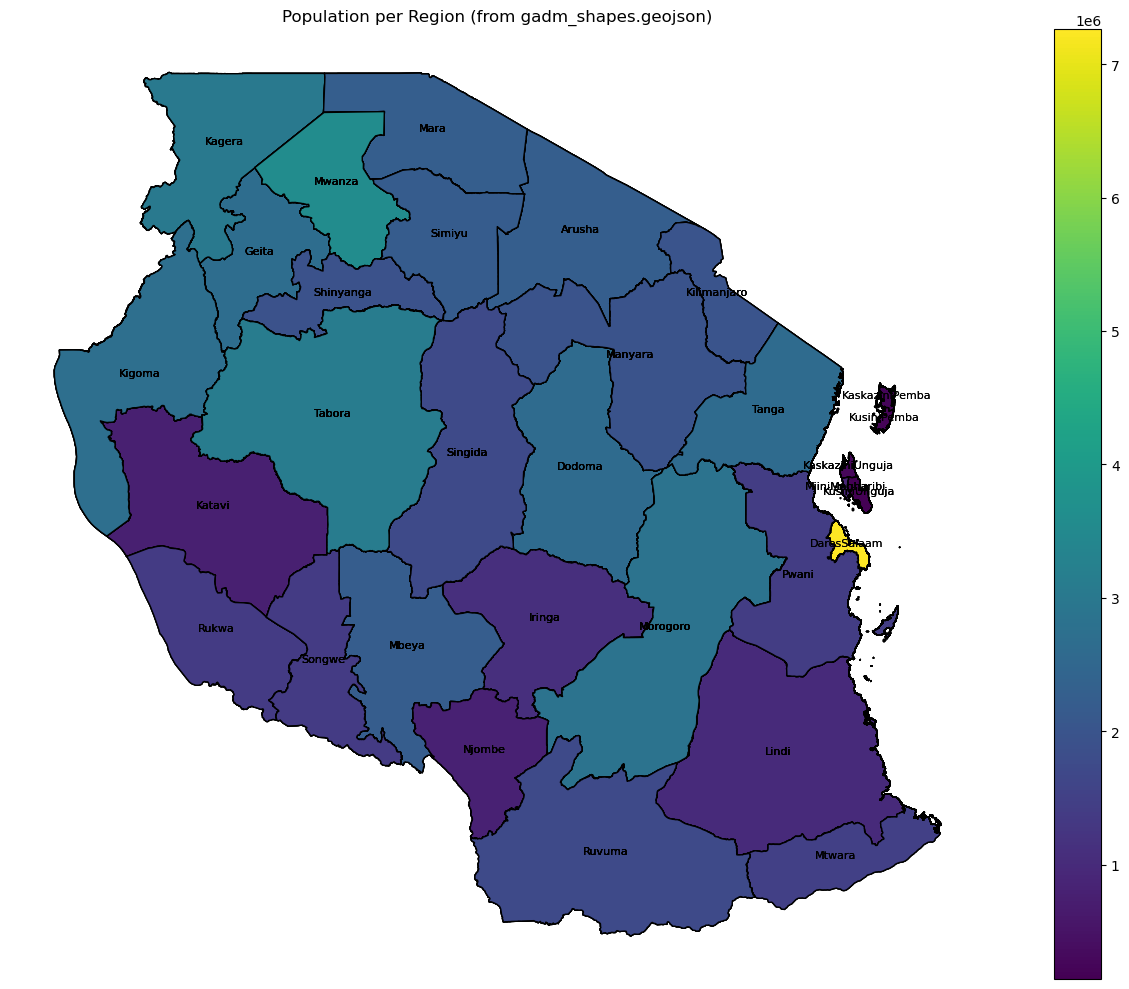

In [28]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load region boundaries with names
regions = gpd.read_file("C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/custom/gadm41_TZA_1.json")
regions = regions.to_crs("EPSG:4326")

# Load GADM shapes with population and GDP, but no names
gadm_shapes = gpd.read_file("C:/Users/hie/pe_tan/pypsa-earth/resources/shapes/gadm_shapes.geojson")
gadm_shapes = gadm_shapes.to_crs("EPSG:4326")

# Spatial join to assign region names from `regions` to `gadm_shapes`
matched = gpd.sjoin(gadm_shapes, regions[["geometry", "NAME_1"]], how="left", predicate="intersects")

# Extract GADM_ID, NAME_1, and Population
pop_by_region = matched.groupby(["GADM_ID", "NAME_1"])["pop"].sum().reset_index()
pop_by_region.columns = ["GADM_ID", "Region", "Population"]
pop_by_region.sort_values(by="Population", ascending=False, inplace=True)

# Save to CSV
pop_by_region.to_csv("matched_population_by_region.csv", index=False)
print(pop_by_region)

pop = pop_by_region["Population"].sum()
print(f"Total population from GADM shapes: {pop}")

# Plot the population per region
fig, ax = plt.subplots(figsize=(14, 10))
pop_plot = matched.merge(pop_by_region, left_on=["GADM_ID", "NAME_1"], right_on=["GADM_ID", "Region"])
pop_plot.plot(column="Population", cmap="viridis", legend=True, ax=ax, edgecolor='black')

for _, row in pop_by_region.iterrows():
    region_geom = regions[regions["NAME_1"] == row["Region"]].geometry.values[0]
    centroid = region_geom.centroid
    ax.text(centroid.x, centroid.y, row["Region"], fontsize=8, ha='center')

plt.title("Population per Region (from gadm_shapes.geojson)")
plt.axis("off")
plt.tight_layout()
plt.show()